## Twine Graph Data Story

Enrique Henestroza Anguiano

3/29/2019

In this data story, we explore graph structure and clustering of stories appearing in interactive fiction competitions (IFComp, Spring Thing) over the past decade, using twine_graph and networkx packages, with clustering using scipy. We additionally look at clustering based on word embeddings from story text, using beautifulsoup and spacy packages.

Python dependencies:
- `numpy`, `scipy`, `matplotlib`
- `beautifulsoup4`
- `networkx`
- `spacy` (with model 'en_core_web_lg')
- `titlecase`
- `twine_graph`

In [1]:
%matplotlib inline

In [2]:
# Load .json passage data for competition stories
import os
from twine_graph import TwineGraph
from titlecase import titlecase

story_names = []
story_data = []
sample_story_idx = 1
for fname in os.listdir("data"):
    story_name = os.path.splitext(fname)[0]
    if story_name.startswith("spring"):
        continue
    story = TwineGraph(os.path.join("data", story_name), in_format="json")
    
    # Remove singleton nodes
    pids_linked = set()
    for passage in story.story["passages"]:
        if passage["links"]:
            pids_linked.add(passage["pid"])
        for link in passage["links"]:
            pids_linked.add(link["destination"]["pid"])
    new_passages = [p for p in story.story["passages"] if p["pid"] in pids_linked]
    story.story["passages"] = new_passages
    
    story_data.append(story)
    story_names.append(titlecase(" ".join(story_name.split('_')[2:])))
print(f"Number of Twine stories: {len(story_data)}")

Number of Twine stories: 138


In [3]:
# Create networkx graphs out of each story
import networkx as nx

story_graphs = []
story_digraphs = []
for story_datum in story_data:
    gdir = nx.DiGraph()
    gundir = nx.Graph()
    for passage in story_datum.story["passages"]:
        for link in passage["links"]:
            gdir.add_edge(passage["name"], link["destination"]["name"])
            gundir.add_edge(passage["name"], link["destination"]["name"])
    story_digraphs.append(gdir)
    story_graphs.append(max(nx.connected_component_subgraphs(gundir), key=len))
print(f"Partial graph structure for \"{story_names[sample_story_idx]}\":\n")
for edge in list(story_digraphs[sample_story_idx].edges)[:10]:
    print(" --> ".join(edge))

Partial graph structure for "Rite of Passage":

Start --> lake
Start --> About
Start --> Beginning
About --> Start
Beginning --> Dramatis Personae
Beginning --> Quote 1
Entry 1 --> Dramatis Personae
Entry 1 --> Entry 2A
Entry 1 --> Entry 2B
Dramatis Personae --> Anna


In [4]:
# Compute structural features for each graph and place in a matrix.
import numpy as np

features = []
for idx in range(len(story_data)):
    graph_size = len(story_data[idx].story["passages"])
    linkd = np.mean([len(p["links"]) for p in story_data[idx].story["passages"]])
    linkmaxd = max([len(p["links"]) for p in story_data[idx].story["passages"]])
    linkmedd = np.median([len(p["links"]) for p in story_data[idx].story["passages"]])
    radius = nx.algorithms.distance_measures.radius(story_graphs[idx])
    diameter = nx.algorithms.distance_measures.diameter(story_graphs[idx])
    features.append([graph_size, linkd, linkmaxd, linkmedd, radius, diameter])
Y_struct = np.log1p(np.asarray(features))

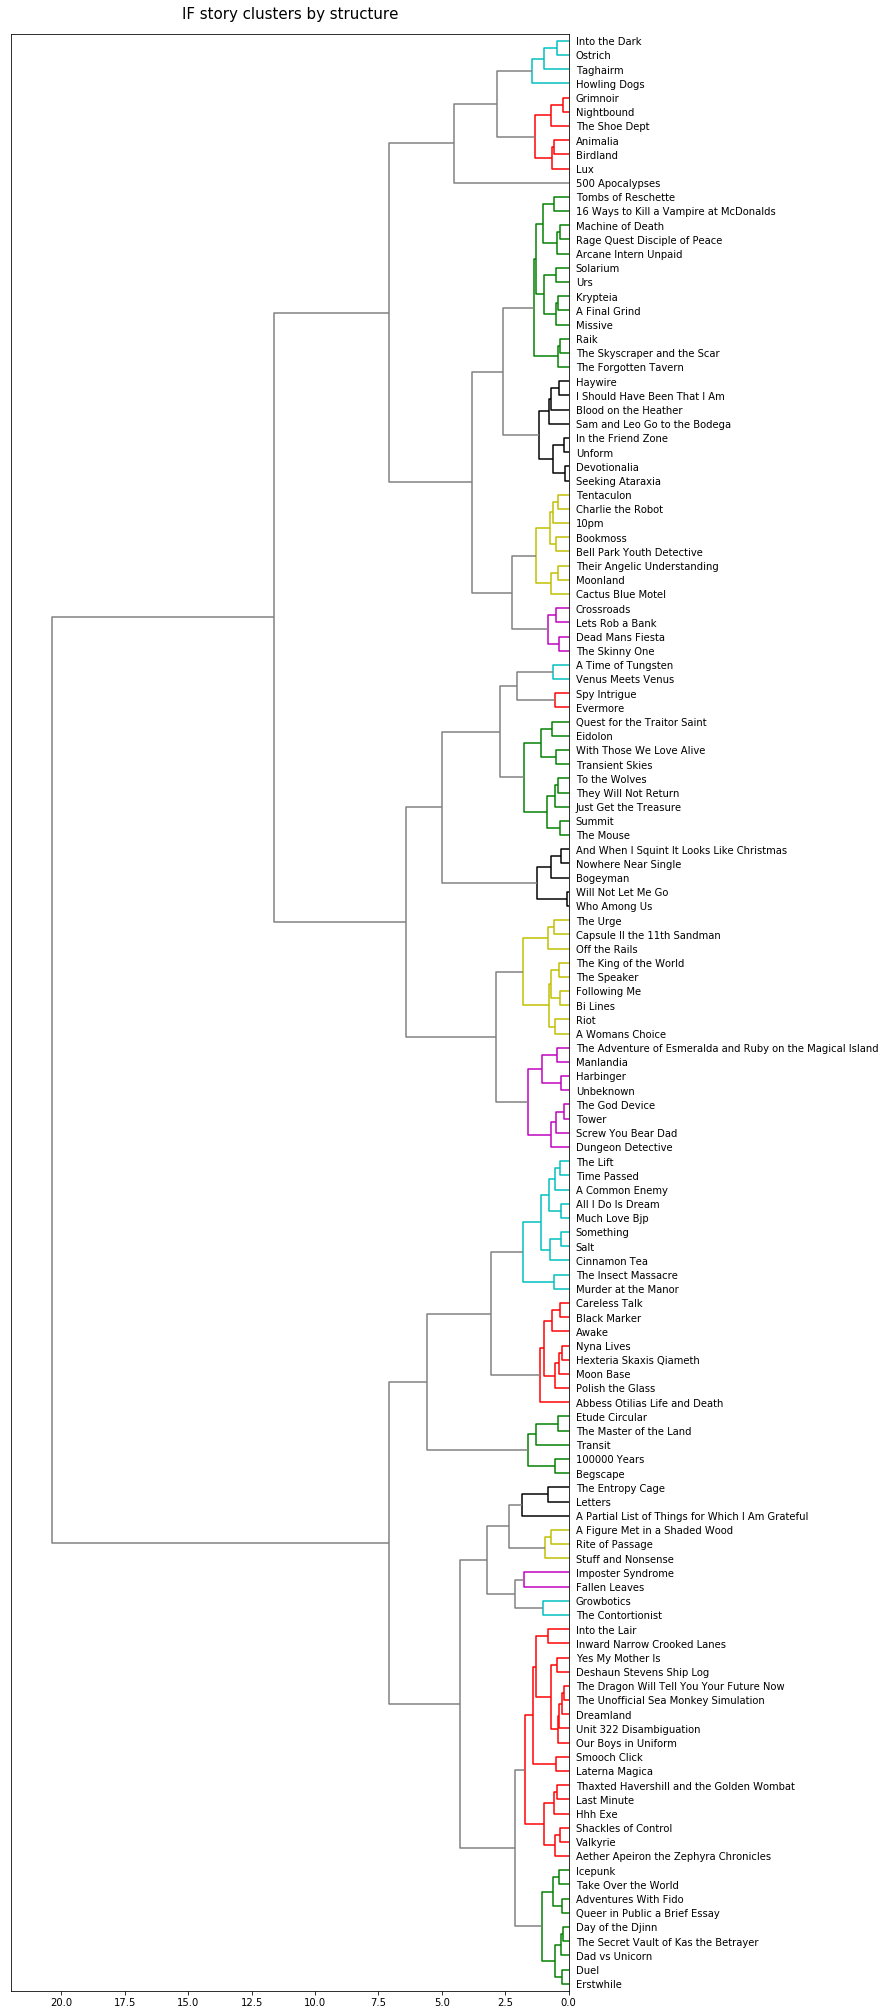

In [5]:
# Produce clustering from structural features.
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

plt.figure(figsize=(10,36))
plt.title('IF story clusters by structure', fontsize=15, pad=15)
Z = linkage(Y_struct, "ward")
fig = dendrogram(Z, labels=story_names, leaf_rotation=0, orientation="left",
                 leaf_font_size=10, color_threshold=2, above_threshold_color='grey')
_ = plt.xlim([22,0])

In [6]:
# Compute word embedding features for each story using spaCy.
import re
import spacy
from bs4 import BeautifulSoup

punct_regex = re.compile(r"[\W_]+")
nlp = spacy.load("en_core_web_lg",  disable=["parser", "ner"])
nlp.max_length = 10000000
features = []
for idx in range(len(story_data)):
    text = " ".join(passage["text"] for passage in story_data[idx].story["passages"])
    soup_text = BeautifulSoup(text, 'lxml').get_text()
    doc = nlp(punct_regex.sub(' ', soup_text))
    clean_tokens = []
    for token in doc:
        if len(token) > 2 and token.tag_[:2] in ["NN", "VB"] and not token.is_stop:
            clean_tokens.append(token.lemma_)
    clean_doc = nlp(" ".join(clean_tokens))
    if idx == sample_story_idx:
        print(f"Partial token list for \"{story_names[sample_story_idx]}\":\n")
        print(clean_tokens[:50])
    features.append(clean_doc.vector)
Y_text = np.asarray(features)

Partial token list for "Rite of Passage":

['display', 'lake', 'align', 'begin', 'begin', 'cnt', 'save', 'game', 'contain', 'Slot', 'replace', 'replace', 'cnt', 'link', 'replace', 'continue', 'load', 'game', 'Slot', 'set', 'quoteline', 'today', 'Monday', '26th', 'September', 'weather', 'like', 'colour', 'summer', 'play', 'cop', 'robber', 'today', 'class', 'break', 'fill', 'courtyard', 'life', 'talk', 'staff', 'room', 'Cloels', 'tell', 'time', 'try', 'catch', 'link', 'goto', 'Christine', 'Dramatis']


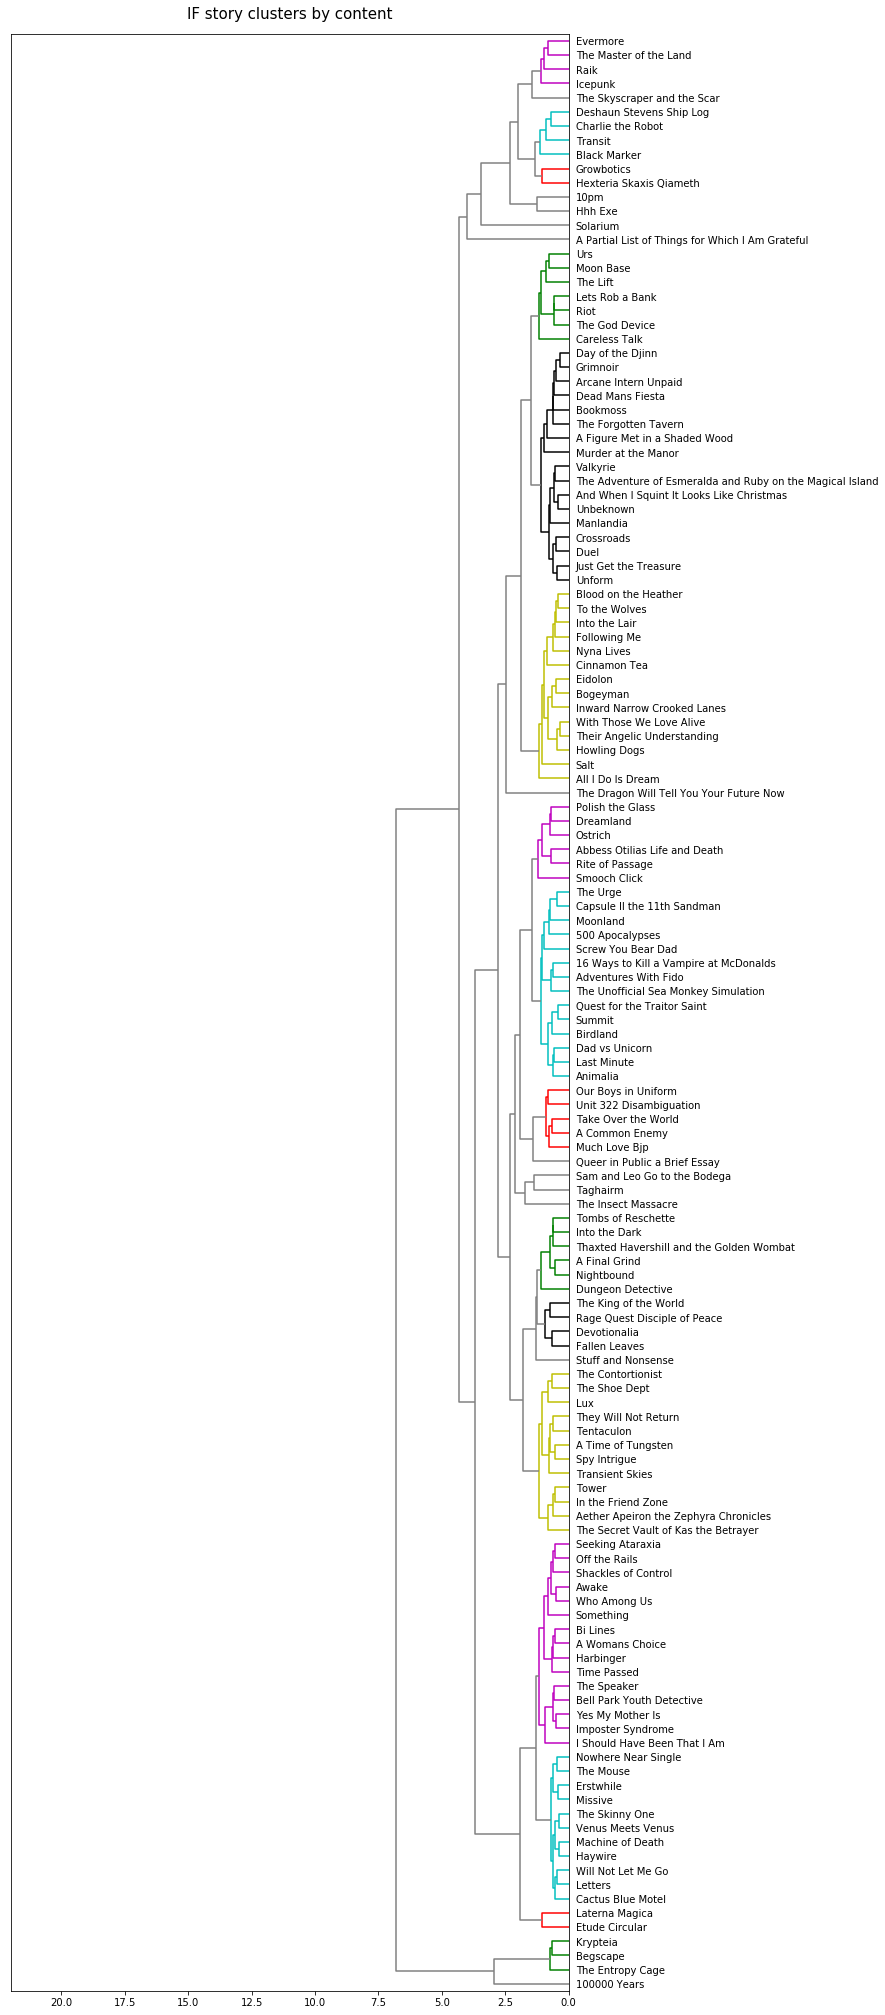

In [7]:
# Produce clustering from word embedding features.
plt.figure(figsize=(10,36))
plt.title('IF story clusters by content', fontsize=15, pad=15)
Z = linkage(Y_text, "ward")
fig = dendrogram(Z, labels=story_names, leaf_rotation=0, orientation="left",
                 leaf_font_size=10, color_threshold=1.25, above_threshold_color='grey')
_ = plt.xlim([22,0])